In [1]:
# _______________________________________________
#  INSTALLS,IMPORTS, MOUNT DRIVE & SETUP PATHS
# _______________________________________________

#  1. INSTALLS
!pip install pytorch-lightning
!pip install nltk
!pip install torch torchvision
#  2. BASIC LIBRARIES
from pathlib import Path
import os, json, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

#  3. TORCH & VISION
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#  4. UTILITIES
import pytorch_lightning as pl

# _______________________________________________
#  MOUNTING GOOGLE DRIVE
# _______________________________________________
from google.colab import drive
drive.mount('/content/drive')

# After running this cell, you'll be asked to authorize access.
# The dataset should be in: MyDrive/flickr30k/
#   ├── Flickr30k_images/
#   ├── flickr_annotations_30k.csv
#   └── flickr30k_captions.json

# _______________________________________________
#  SETTING UP PATHS
# _______________________________________________
DATA_DIR = Path("/content/drive/MyDrive")
IMAGES_DIR = DATA_DIR / "Flickr30k_images"
CSV_FILE = DATA_DIR / "flickr_annotations_30k.csv"
CAPTIONS_FILE = DATA_DIR / "flickr30k_captions.json"

# _______________________________________________
#  CHECKING GPU AVAILABILITY
# _______________________________________________
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

# _______________________________________________
#  VERIFYING FILES EXIST
# _______________________________________________
print("Images folder exists:", IMAGES_DIR.exists())
print("Captions CSV exists:", CSV_FILE.exists())
print("Captions JSON exists:", CAPTIONS_FILE.exists())

# _______________________________________________
# 🧩 LIBRARY VERSION CHECKS
# _______________________________________________
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("PyTorch Lightning:", pl.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
GPU: Tesla T4
Images folder exists: True
Captions CSV exists: True
Captions JSON exists: True
PyTorch: 2.8.0+cu126
Torchvision: 0.23.0+cu126
PyTorch Lightning: 2.5.5


In [2]:
# _______________________________________________
#  CONVERT CAPTIONS CSV TO JSON (FIXED FOR YOUR FILE)
# _______________________________________________
import pandas as pd
import json
import ast  # to safely evaluate list strings

df = pd.read_csv(CSV_FILE)
print("📄 CSV columns:", df.columns.tolist())
print(df.head(2))

# We know:
# - "filename" contains image names
# - "raw" contains a list of captions as a string
image_col = "filename"
captions_col = "raw"

captions = {}

for _, row in df.iterrows():
    img = str(row[image_col]).strip()
    raw_caps = row[captions_col]

    # Safely convert string list -> actual Python list
    try:
        caps_list = ast.literal_eval(raw_caps)
    except Exception:
        continue

    # Clean and normalize each caption
    clean_caps = []
    for cap in caps_list:
        cap = cap.lower().strip()
        cap = cap.replace("’", "'").replace('"', "")
        cap = " ".join(cap.split())
        clean_caps.append(cap)

    captions[img] = clean_caps

# Save as JSON
with open(CAPTIONS_FILE, "w", encoding="utf-8") as f:
    json.dump(captions, f, indent=2)

print(f"✅ Captions JSON saved at: {CAPTIONS_FILE}")
print(f"Total images: {len(captions)}")
print("\nSample entry:")
sample_key = list(captions.keys())[0]
print(sample_key, "→", captions[sample_key])

📄 CSV columns: ['raw', 'sentids', 'split', 'filename', 'img_id']
                                                 raw          sentids  split  \
0  ["Two young guys with shaggy hair look at thei...  [0, 1, 2, 3, 4]  train   
1  ["Several men in hard hats are operating a gia...  [5, 6, 7, 8, 9]  train   

         filename  img_id  
0  1000092795.jpg       0  
1    10002456.jpg       1  
✅ Captions JSON saved at: /content/drive/MyDrive/flickr30k_captions.json
Total images: 31014

Sample entry:
1000092795.jpg → ['two young guys with shaggy hair look at their hands while hanging out in the yard.', 'two young, white males are outside near many bushes.', 'two men in green shirts are standing in a yard.', 'a man in a blue shirt standing in a garden.', 'two friends enjoy time spent together.']


Total images with captions: 31014

🖼️ Image name: 4696281191.jpg
📜 Captions:
1. a dark-haired woman in a white dress adjusts her high heel as she stands beside a table with a white tablecloth and two chairs beside a body of water.
2. a lady dressed in a white, short dress is next to a table set for two with a rock pier in the background.
3. girl dressed in white dress and black heels standing by small table and chairs, with ocean in background.
4. there is a woman next to a dinner table, by the ocean, standing on one leg.
5. a woman in a white dress touches her foot.


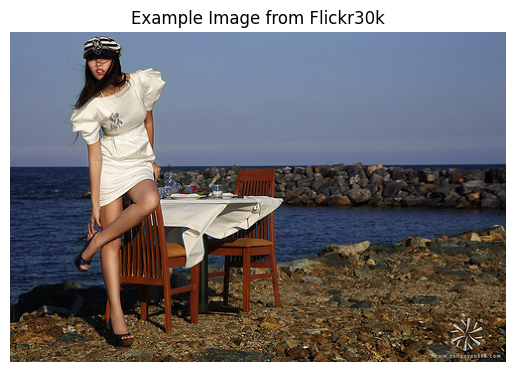

In [3]:
# _______________________________________________
#  VERIFY AND VISUALIZE THE DATASET
# _______________________________________________
import json
import matplotlib.pyplot as plt
from PIL import Image
import random

# Load captions JSON
with open(CAPTIONS_FILE, "r", encoding="utf-8") as f:
    data = json.load(f)

print(f"Total images with captions: {len(data)}")

# Pick a random sample
sample_key = random.choice(list(data.keys()))
print(f"\n Image name: {sample_key}")
print(" Captions:")
for i, cap in enumerate(data[sample_key], 1):
    print(f"{i}. {cap}")

# Show the image
img_path = IMAGES_DIR / sample_key
if img_path.exists():
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Example Image from Flickr30k")
    plt.show()
else:
    print(" Image file not found:", img_path)

In [4]:
# _______________________________________________
#  BUILD VOCABULARY
# _______________________________________________
import nltk
from collections import Counter
nltk.download('punkt')

class Vocabulary:
    """
    Converts words <-> numeric indices.
    Also filters out rare words.
    """
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.word_freq = Counter()

    def build_vocab(self, sentence_list):
        for sentence in sentence_list:
            for word in nltk.word_tokenize(sentence.lower()):
                self.word_freq[word] += 1

        idx = len(self.itos)
        for word, freq in self.word_freq.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokens = nltk.word_tokenize(text.lower())
        return [self.stoi.get(token, self.stoi["<unk>"]) for token in tokens]

print("✅ Vocabulary class ready.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✅ Vocabulary class ready.


In [5]:
# _______________________________________________
#  FIXING FOR NLTK "punkt_tab not found" ERROR
# _______________________________________________
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')  # 👈 new tokenizer table added in recent NLTK versions

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
# _______________________________________________
#  BUILDING VOCABULARY FROM CAPTIONS
# _______________________________________________
all_captions = []
for caps in data.values():
    all_captions.extend(caps)

vocab = Vocabulary(freq_threshold=5)
vocab.build_vocab(all_captions)

print("✅ Vocabulary built.")
print("Total unique words:", len(vocab.itos))
print("Example words:", list(vocab.stoi.keys())[:20])

✅ Vocabulary built.
Total unique words: 7691
Example words: ['<pad>', '<start>', '<end>', '<unk>', 'two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the', 'yard']


In [7]:
# _______________________________________________
# CREATEING DATASET CLASS
# _______________________________________________
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch

class FlickrDataset(Dataset):
    def __init__(self, img_dir, captions_dict, vocab, transform=None, max_length=30):
        self.img_dir = img_dir
        self.captions_dict = captions_dict
        self.image_files = list(captions_dict.keys())
        self.vocab = vocab
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        captions = self.captions_dict[img_name]
        caption = random.choice(captions)  # pick one random caption per image

        # Image
        img_path = self.img_dir / img_name
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Text → tokens
        tokens = [self.vocab.stoi["<start>"]]
        tokens += self.vocab.numericalize(caption)
        tokens.append(self.vocab.stoi["<end>"])

        # Pad/truncate
        if len(tokens) < self.max_length:
            tokens += [self.vocab.stoi["<pad>"]] * (self.max_length - len(tokens))
        else:
            tokens = tokens[:self.max_length]
            tokens[-1] = self.vocab.stoi["<end>"]

        caption_tensor = torch.tensor(tokens)
        return image, caption_tensor

print("✅ Dataset class ready.")

✅ Dataset class ready.


In [8]:
# _______________________________________________
#  TESTING DATASET LOADING
# _______________________________________________
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FlickrDataset(IMAGES_DIR, data, vocab, transform=transform)
print("Total samples:", len(dataset))

# Test one sample
img, cap = dataset[0]
print("Image tensor shape:", img.shape)
print("Caption tensor:", cap)
print("Decoded caption:")
print(" ".join([vocab.itos[idx.item()] for idx in cap if idx.item() > 3]))

Total samples: 31014
Image tensor shape: torch.Size([3, 224, 224])
Caption tensor: tensor([ 1,  4, 38, 39, 40,  3, 41, 20,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
Decoded caption:
two friends enjoy time together .


In [9]:
# _______________________________________________
#  ENCODER: CNN FEATURE EXTRACTOR (RESNET50)
# _______________________________________________
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size=256, train_cnn=False):
        """
        Parameters:
        -----------
        embed_size : int
            Dimension of the feature vector output.
        train_cnn : bool
            Whether to fine-tune CNN layers (set False for now).
        """
        super(EncoderCNN, self).__init__()

        # Load pretrained ResNet-50
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Remove the classification layer
        modules = list(resnet.children())[:-1]  # everything except the last FC layer
        self.resnet = nn.Sequential(*modules)

        # Projection layer: convert CNN output -> embedding vector
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # Freeze or unfreeze CNN layers
        for param in self.resnet.parameters():
            param.requires_grad = train_cnn

    def forward(self, images):
        """
        Forward pass through the encoder.
        Input:  images (batch_size, 3, 224, 224)
        Output: feature embeddings (batch_size, embed_size)
        """
        with torch.no_grad():  # disable gradients for ResNet if frozen
            features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.linear(features)
        features = self.bn(features)
        return features

print("✅ EncoderCNN class ready.")

✅ EncoderCNN class ready.


In [10]:
# _______________________________________________
#  TEST ENCODER OUTPUT  (Fixed for batchnorm)
# _______________________________________________
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = EncoderCNN(embed_size=256).to(device)

# Switch to evaluation mode so BatchNorm works with 1 sample
encoder.eval()

# Get one sample from dataset
img, _ = dataset[0]
img = img.unsqueeze(0).to(device)  # add batch dimension

# Forward pass (no gradients)
with torch.no_grad():
    features = encoder(img)

print("Feature vector shape:", features.shape)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


Feature vector shape: torch.Size([1, 256])


In [11]:
# _______________________________________________
#  DECODER: LSTM CAPTION GENERATOR
# _______________________________________________
import torch
import torch.nn as nn

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        Parameters:
        -----------
        embed_size : int
            Size of word embedding vector
        hidden_size : int
            Hidden state size of the LSTM
        vocab_size : int
            Total number of words in the vocabulary
        num_layers : int
            Number of LSTM layers
        """
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        """
        Input:
            features: encoded image tensor (batch, embed_size)
            captions: tensor of word indices (batch, max_seq_length)
        Output:
            outputs: vocabulary scores for each time step
        """
        embeddings = self.dropout(self.embed(captions[:, :-1]))  # remove <end>
        features = features.unsqueeze(1)  # (batch, 1, embed_size)
        inputs = torch.cat((features, embeddings), dim=1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.linear(hiddens)
        return outputs

print("✅ DecoderRNN class ready.")

✅ DecoderRNN class ready.


In [12]:
# _______________________________________________
#  TEST ENCODER + DECODER PIPELINE
# _______________________________________________
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
embed_size = 256
hidden_size = 512
vocab_size = len(vocab.itos)

# Initialize models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)

# Get one sample
img, caption = dataset[0]
img = img.unsqueeze(0).to(device)
caption = caption.unsqueeze(0).to(device)

# Forward pass
encoder.eval()
with torch.no_grad():
    features = encoder(img)

outputs = decoder(features, caption)
print("Decoder output shape:", outputs.shape)

Decoder output shape: torch.Size([1, 30, 7691])


In [13]:
# _______________________________________________
#  TRAINING SETUP: LOSS, OPTIMIZER, PARAMETERS
# _______________________________________________
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
embed_size = 256
hidden_size = 512
vocab_size = len(vocab.itos)
learning_rate = 3e-4
num_epochs = 2        # start small just to test training
batch_size = 64

# Models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<pad>"])
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = optim.Adam(params, lr=learning_rate)

print("✅ Training components ready.")

✅ Training components ready.


In [14]:
# _______________________________________________
#  DATA LOADER SETUP
# _______________________________________________
from torch.utils.data import DataLoader

def collate_fn(batch):
    """Merge a list of (image, caption) pairs into batch tensors."""
    images = torch.stack([item[0] for item in batch])
    captions = torch.stack([item[1] for item in batch])
    return images, captions

data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
print("✅ DataLoader ready. Total batches per epoch:", len(data_loader))

✅ DataLoader ready. Total batches per epoch: 485


In [15]:
# _______________________________________________
# CREATE SMALLER DATALOADER
# _______________________________________________
from torch.utils.data import DataLoader, Subset
import random

# Use only 500 samples (change number if needed)
subset_size = 500
small_indices = random.sample(range(len(dataset)), subset_size)
small_dataset = Subset(dataset, small_indices)

small_loader = DataLoader(
    small_dataset, batch_size=24, shuffle=True, collate_fn=collate_fn
)

data_loader = small_loader  # override main loader
num_epochs = 5  # for quick test

print(f"✅ Using subset of {subset_size} samples for quick training.")

✅ Using subset of 500 samples for quick training.


In [16]:
# _______________________________________________
# QUICK TRAINING LOOP (FAST TEST)
# _______________________________________________
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0

    for i, (imgs, captions) in enumerate(data_loader):
        imgs, captions = imgs.to(device), captions.to(device)

        # Forward pass
        features = encoder(imgs)
        outputs = decoder(features, captions)

        # Align targets
        targets = captions[:, 1:]
        outputs = outputs[:, :targets.size(1), :]

        # Loss
        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i + 1) % 10 == 0:
            print(f"Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}")

    print(f"✅ Epoch [{epoch+1}/{num_epochs}] completed — Avg Loss: {total_loss / len(data_loader):.4f}")


Step [10/21], Loss: 8.8359
Step [20/21], Loss: 8.4179
✅ Epoch [1/5] completed — Avg Loss: 8.7551
Step [10/21], Loss: 6.2040
Step [20/21], Loss: 6.1022
✅ Epoch [2/5] completed — Avg Loss: 6.4965
Step [10/21], Loss: 5.9667
Step [20/21], Loss: 5.7298
✅ Epoch [3/5] completed — Avg Loss: 5.7508
Step [10/21], Loss: 5.6106
Step [20/21], Loss: 5.1476
✅ Epoch [4/5] completed — Avg Loss: 5.5522
Step [10/21], Loss: 5.3420
Step [20/21], Loss: 5.2889
✅ Epoch [5/5] completed — Avg Loss: 5.4578


In [17]:
# _______________________________________________
#  TRAINING LOOP (ALIGN OUTPUTS & TARGETS)
# _______________________________________________
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0

    for i, (imgs, captions) in enumerate(data_loader):
        imgs, captions = imgs.to(device), captions.to(device)

        # Forward pass
        features = encoder(imgs)
        outputs = decoder(features, captions)  # shape: (batch, seq_len-1, vocab_size)

        # Align targets properly (exclude <start> token)
        targets = captions[:, 1:]  # shift by 1 to predict next word

        # Make sure both have the same sequence length
        outputs = outputs[:, :targets.size(1), :]  # trim if needed

        # Compute loss
        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(data_loader)
    print(f"✅ Epoch [{epoch+1}/{num_epochs}] completed — Average Loss: {avg_loss:.4f}\n")

✅ Epoch [1/5] completed — Average Loss: 5.3359

✅ Epoch [2/5] completed — Average Loss: 5.2493

✅ Epoch [3/5] completed — Average Loss: 5.2091

✅ Epoch [4/5] completed — Average Loss: 5.1570

✅ Epoch [5/5] completed — Average Loss: 5.0772



In [18]:
# _______________________________________________
# 6️⃣.3.4 SAVE TRAINED MODELS
# _______________________________________________
torch.save({
    'encoder': encoder.state_dict(),
    'decoder': decoder.state_dict(),
    'vocab': vocab.stoi
}, "image_captioning_model.pth")

print("💾 Model saved successfully!")

💾 Model saved successfully!


In [19]:
# _______________________________________________
# LOAD TRAINED MODEL
# _______________________________________________

checkpoint_path = "image_captioning_model.pth"

checkpoint = torch.load(checkpoint_path, map_location=device)

encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
vocab.stoi = checkpoint['vocab']
vocab.itos = {v: k for k, v in vocab.stoi.items()} # Rebuild itos as well

encoder.eval()
decoder.eval()

print("✅ Model loaded successfully and ready for captioning!")

✅ Model loaded successfully and ready for captioning!


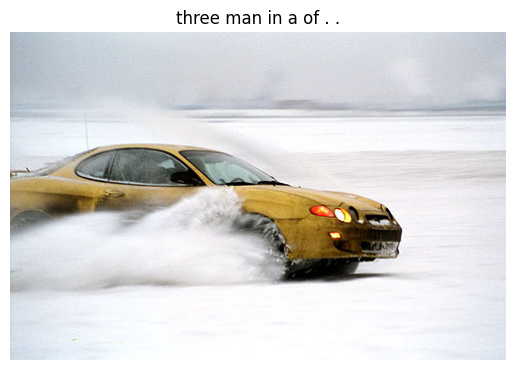

🗣️ Generated Caption: three man in a of . .


In [20]:
# _______________________________________________
# CAPTIONING RANDOM IMAGE
# _______________________________________________
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import os
import random

# Preprocessing (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

def generate_caption(image_path, max_len=20):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = encoder(img_tensor)

    caption = [vocab.stoi["<start>"]]
    for _ in range(max_len):
        cap_tensor = torch.tensor(caption).unsqueeze(0).to(device)
        with torch.no_grad():
            output = decoder(features, cap_tensor)
        next_word = output.argmax(2)[:, -1].item()
        caption.append(next_word)
        if vocab.itos[next_word] == "<end>":
            break

    words = [vocab.itos[idx] for idx in caption[1:-1]]
    return " ".join(words), image

# Example: pick any image from the dataset
image_files = list(data.keys()) # Use the keys from the loaded captions data
sample_image_name = random.choice(image_files)
sample_image_path = IMAGES_DIR / sample_image_name

caption, img = generate_caption(sample_image_path)
plt.imshow(img)
plt.axis("off")
plt.title(caption)
plt.show()

print("🗣️ Generated Caption:", caption)

In [21]:
# _______________________________________________
# SEGMENTATION — SETUP
# _______________________________________________

# 1️⃣ Imports
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 2️⃣ Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

# 3️⃣ Load Pretrained Mask R-CNN
model = maskrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

print("✅ Mask R-CNN loaded successfully!")

Using device: cuda
GPU: Tesla T4


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:00<00:00, 185MB/s]


✅ Mask R-CNN loaded successfully!


Checking image directory: /content/drive/MyDrive/Flickr30k_images
Does image directory exist: True


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


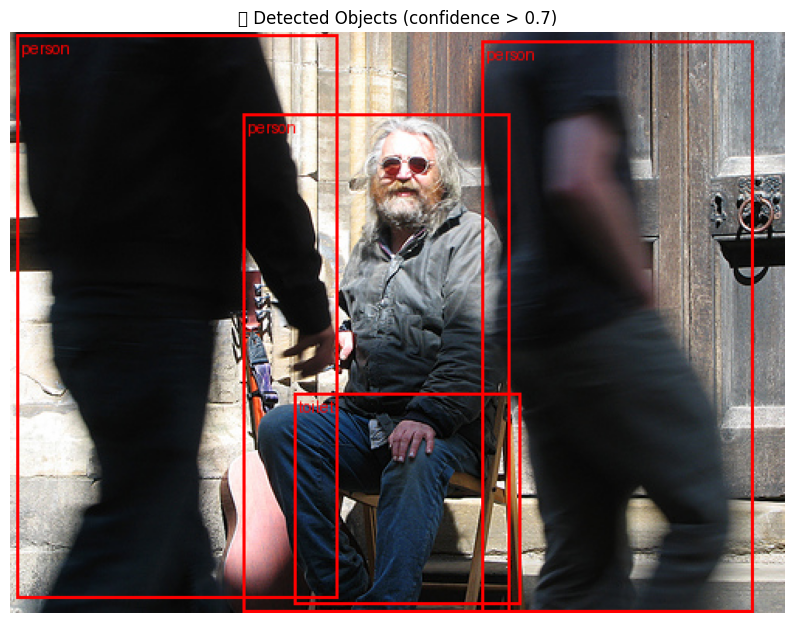

🖼️ Random image: 502529086.jpg
Detected objects: ['person', 'person', 'person', 'toilet']


In [22]:
# _______________________________________________
# SEGMENTATION — TEST ON RANDOM FLICKR30K IMAGE
# _______________________________________________
import os, random
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F

# 1️⃣ Pick a random image from Flickr30k_images folder
# Use the IMAGES_DIR variable defined earlier
IMG_DIR = IMAGES_DIR
print(f"Checking image directory: {IMG_DIR}")
print(f"Does image directory exist: {IMG_DIR.exists()}")

# Check if the directory is empty before listing
if not any(os.scandir(IMG_DIR)):
    print(f"Error: Image directory {IMG_DIR} is empty.")
else:
    sample_img = random.choice(os.listdir(IMG_DIR))
    img_path = os.path.join(IMG_DIR, sample_img)

    # 2️⃣ Load & preprocess image
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    img_tensor = transform(image).to(device)

    # 3️⃣ Run the model
    with torch.no_grad():
        prediction = model([img_tensor])[0]

    # 4️⃣ Extract predictions with confidence > 0.7
    threshold = 0.7
    keep = prediction['scores'] > threshold
    boxes = prediction['boxes'][keep]
    labels = prediction['labels'][keep]
    masks = prediction['masks'][keep]

    # 5️⃣ Prepare visualization
    # Convert mask probabilities → binary masks
    masks = (masks > 0.5).squeeze(1)

    # Define COCO class names (common for Mask R-CNN pretrained models)
    COCO_INSTANCE_CATEGORY_NAMES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
        'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
        'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
        'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
        'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
        'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]

    # Map labels to names
    predicted_class_names = [COCO_INSTANCE_CATEGORY_NAMES[i.item()] for i in labels]


    # Draw boxes on CPU tensor for matplotlib display
    box_image = draw_bounding_boxes(
        (img_tensor.cpu() * 255).byte(),
        boxes=boxes.cpu(),
        labels=predicted_class_names,
        colors="red",
        width=2
    )

    # Convert tensor → PIL for display
    box_image = F.to_pil_image(box_image)

    # 6️⃣ Display results
    plt.figure(figsize=(10, 8))
    plt.imshow(box_image)
    plt.axis("off")
    plt.title(f"🖼️ Detected Objects (confidence > {threshold})")
    plt.show()

    print("🖼️ Random image:", sample_img)
    print("Detected objects:", predicted_class_names)

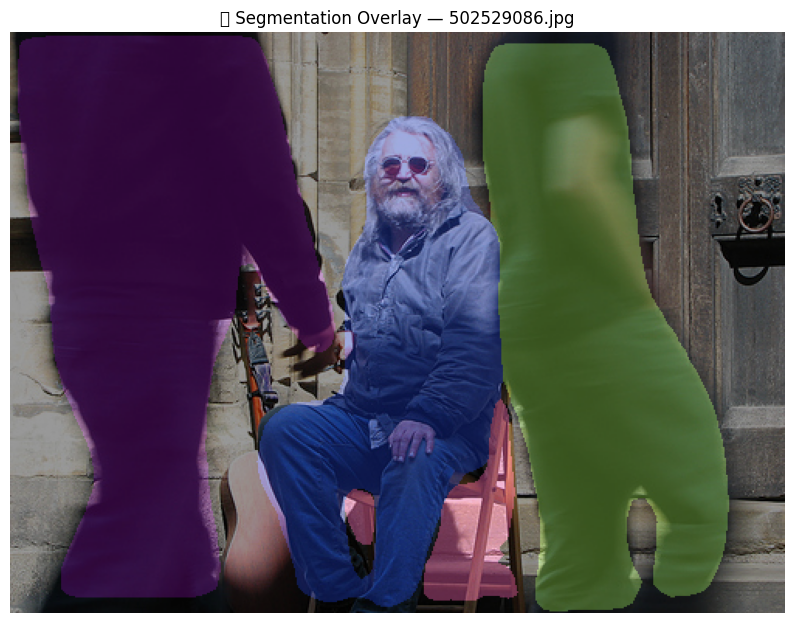

In [23]:
# _______________________________________________
# SEGMENTATION — ADD COLORED MASK OVERLAY
# _______________________________________________
import matplotlib.patches as mpatches
import random
import numpy as np

# Make a copy of the original image as NumPy array
image_np = np.array(image)

# Overlay each mask with a random color
colored_mask = np.zeros_like(image_np)
for mask, label in zip(masks.cpu().numpy(), predicted_class_names):
    color = [random.randint(0, 255) for _ in range(3)]
    binary_mask = mask.astype(bool)
    colored_mask[binary_mask] = color

# Blend original image + mask overlay (0.6 transparency)
blended = (0.6 * image_np + 0.4 * colored_mask).astype(np.uint8)

# Display
plt.figure(figsize=(10, 8))
plt.imshow(blended)
plt.axis("off")
plt.title(f"🖼️ Segmentation Overlay — {sample_img}")
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128483 (\N{SPEAKING HEAD IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


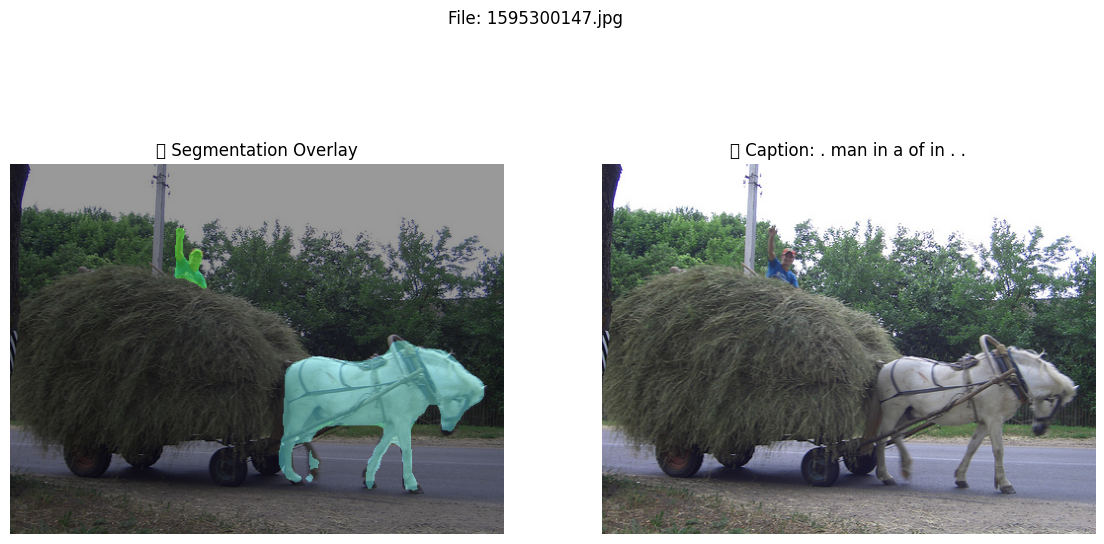

🖼️ Image: 1595300147.jpg
🗣️ Generated Caption: . man in a of in . .
🎯 Detected Objects: ['sheep', 'person']


In [24]:
# _______________________________________________
# INTEGRATION OF CAPTION + SEGMENTATION
# _______________________________________________
import os, random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

# 1️⃣ Pick a random image from Flickr30k
IMG_DIR = IMAGES_DIR
sample_img = random.choice(os.listdir(IMG_DIR))
img_path = os.path.join(IMG_DIR, sample_img)
image = Image.open(img_path).convert("RGB")

# 2️⃣ Prepare tensor for segmentation
seg_transform = transforms.Compose([transforms.ToTensor()])
img_tensor = seg_transform(image).to(device)

# 3️⃣ Run Mask R-CNN segmentation
with torch.no_grad():
    prediction = model([img_tensor])[0]

threshold = 0.7
keep = prediction['scores'] > threshold
boxes = prediction['boxes'][keep]
labels = prediction['labels'][keep]
masks = prediction['masks'][keep]
masks = (masks > 0.5).squeeze(1)

# COCO labels
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
predicted_names = [COCO_CLASSES[i.item()] for i in labels]

# 4️⃣ Generate a caption using your trained captioning model
def generate_caption(image_pil, max_len=20):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])
    img_tensor = transform(image_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        features = encoder(img_tensor)

    caption = [vocab.stoi["<start>"]]
    for _ in range(max_len):
        caption_tensor = torch.tensor(caption).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = decoder(features, caption_tensor)
        next_word = outputs.argmax(2)[:, -1].item()
        caption.append(next_word)
        if vocab.itos[next_word] == "<end>":
            break

    words = [vocab.itos[idx] for idx in caption[1:-1]]
    return " ".join(words)

caption_text = generate_caption(image)

# 5️⃣ Create segmentation mask overlay
image_np = np.array(image)
colored_mask = np.zeros_like(image_np)
for mask in masks.cpu().numpy():
    color = [random.randint(0, 255) for _ in range(3)]
    colored_mask[mask.astype(bool)] = color

blended = (0.6 * image_np + 0.4 * colored_mask).astype(np.uint8)

# 6️⃣ Display side by side
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(blended)
plt.axis("off")
plt.title("🧩 Segmentation Overlay")

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.axis("off")
plt.title(f"🗣️ Caption: {caption_text}")

plt.suptitle(f"File: {sample_img}", fontsize=12)
plt.show()

print("🖼️ Image:", sample_img)
print("🗣️ Generated Caption:", caption_text)
print("🎯 Detected Objects:", predicted_names)

In [25]:
# _______________________________________________
# INTERACTIVE DEMO (SEGMENT + CAPTION)
# _______________________________________________
!pip install gradio -q

import gradio as gr
import numpy as np
from PIL import Image
import random
import torch
from torchvision import transforms

# 1️⃣ Define preprocessing transforms
caption_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

seg_transform = transforms.Compose([transforms.ToTensor()])

# 2️⃣ Define combined function for segmentation + caption
def segment_and_caption(image):
    # Convert input to PIL if not already
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image).convert("RGB")

    # ---- Segmentation ----
    img_tensor = seg_transform(image).to(device)
    with torch.no_grad():
        prediction = model([img_tensor])[0]

    threshold = 0.7
    keep = prediction['scores'] > threshold
    masks = prediction['masks'][keep]
    labels = prediction['labels'][keep]
    masks = (masks > 0.5).squeeze(1)

    # COCO class labels
    COCO_CLASSES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
        'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
        'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
        'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
        'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
        'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]
    predicted_names = [COCO_CLASSES[i.item()] for i in labels]

    # Create colored mask overlay
    image_np = np.array(image)
    colored_mask = np.zeros_like(image_np)
    for mask in masks.cpu().numpy():
        color = [random.randint(0, 255) for _ in range(3)]
        colored_mask[mask.astype(bool)] = color
    blended = (0.6 * image_np + 0.4 * colored_mask).astype(np.uint8)

    # ---- Captioning ----
    img_tensor_cap = caption_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = encoder(img_tensor_cap)

    caption = [vocab.stoi["<start>"]]
    for _ in range(20):
        caption_tensor = torch.tensor(caption).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = decoder(features, caption_tensor)
        next_word = outputs.argmax(2)[:, -1].item()
        caption.append(next_word)
        if vocab.itos[next_word] == "<end>":
            break
    caption_text = " ".join([vocab.itos[i] for i in caption[1:-1]])

    return Image.fromarray(blended), caption_text

# 3️⃣ Launch Gradio app
demo = gr.Interface(
    fn=segment_and_caption,
    inputs=gr.Image(type="pil", label="Upload Image"),
    outputs=[
        gr.Image(type="pil", label="Segmented Image"),
        gr.Textbox(label="Generated Caption")
    ],
    title="🧠 Image Captioning + Segmentation Demo",
    description="Upload an image to see Mask R-CNN segmentation and your model's generated caption."
)

demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1042a973750ccf5f4e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1042a973750ccf5f4e.gradio.live
